## EDA
First I will conduct exploratory data analysis to see how the data looks like and how we should approach modelling it

In [1]:
import pandas as pd
import numpy as np
import sqlite3 as sql3

In [2]:
#master query
MASTER_QUERY = 'SELECT * FROM sqlite_master'

# examine tables within the provided database
con = sql3.connect('data/data.db')
cursor = con.cursor()
cursor.execute(MASTER_QUERY)
cursor.fetchall()

[('table',
  'homes',
  'homes',
  2,
  'CREATE TABLE "homes" (\n"id" TEXT,\n  "multiple_occupancy" INTEGER\n)'),
 ('table',
  'motion',
  'motion',
  5,
  'CREATE TABLE "motion" (\n"id" TEXT,\n  "home_id" TEXT,\n  "datetime" TEXT,\n  "location" TEXT\n)')]

There are two data tables present in the the database, homes table (with two schemas) and motion database (with five schemas). Homes contains our target variable, Motion - raw data we can use for modelling.

In [3]:
# write SQL queries
HOME_QUERY = "SELECT * from homes"
MOTION_QUERY = "SELECT * from motion"

# get data
homes_df = pd.read_sql_query(HOME_QUERY, con)
motion_df = pd.read_sql_query(MOTION_QUERY, con)

### home_df

In [25]:
#visualise
homes_df.head()

,home_id,multiple_occupancy
0,dc922bd9bf8a2a9437642fe0dce9dcaa,0
1,d40fc88629271da7b5833ed3f3222d17,1
2,3fb064da180f02862063eca8e3b609c0,1
3,16d71b9c46d9abd765bf395818efe527,0
4,458264665736fd26184a8ea5641e6c48,1


In [26]:
#info on missingness
homes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   home_id             106 non-null    object
 1   multiple_occupancy  106 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [27]:
#describe dataset 
homes_df.describe(include='all')

,home_id,multiple_occupancy
count,106,106.000000
unique,106,NaN
top,dc922bd9bf8a2a9437642fe0dce9dcaa,NaN
freq,1,NaN
mean,NaN,0.575472
std,NaN,0.496619
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [28]:
#count no. single & multiple occupied households
homes_df.groupby('multiple_occupancy').count()

,home_id
multiple_occupancy,
0,45
1,61


Mutliple occupancy is our target variable so it's a binary classification; each id represents a sample we use for modelling. No obvious missingness/nans. There is more multiple occupancy households than single occupancy households so stratification will be needed when splitting into train-test.

There is also not much data - while 106 should be enough for a simple model, after splitting it into train & test set we will have not even 100 samples per development set, not giving us enough confidence in our model's performance. We should seek more data if possible.

### motion_df

In [29]:
#visualise motion_df
motion_df.head()

,id,home_id,datetime,location
0,e41218b439d933a1cd9ad158f78e9198,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:00:10+00,lounge
1,92d48d869ae50b0764cfb8d70494f618,7d2f2e0a9e059b4fb8106bb0ad4b8a39,2024-01-01 00:00:17+00,lounge
2,65c18ba64884442dd47c2fd4cf3630e4,44a880cc6fc3a7db3464092f650ae7f1,2024-01-01 00:00:18+00,lounge
3,90d6336d189c929aa50fa08e5aee5f41,49b83fce41b676266b98cd1e095f1c11,2024-01-01 00:00:43+00,lounge
4,6e3d73bed24b95ffdfe5ec017787f039,14328a0b7574e912c2e23d62c9476a07,2024-01-01 00:00:57+00,lounge


In [9]:
#info on missingness
motion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580317 entries, 0 to 580316
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        580317 non-null  object
 1   home_id   580317 non-null  object
 2   datetime  580317 non-null  object
 3   location  580317 non-null  object
dtypes: object(4)
memory usage: 17.7+ MB


In [23]:
#describe motion_df
motion_df.describe(include='all')


,id,home_id,datetime,location
count,580317,580317,580317,580317
unique,580317,50,502280,10
top,e41218b439d933a1cd9ad158f78e9198,3a1f53e2e242bff03301a250135f894b,2024-01-19 09:09:52+00,kitchen
freq,1,26472,6,158415


In [24]:
#count the number of observations per house
counted = motion_df.groupby('home_id').count()
counted.id.max()

26472

As expected, each house will have a different number of activations.

In [12]:
#count all locations
motion_df.groupby('location').count()

,id,home_id,datetime
location,,,
WC1,10723,10723,10723
bathroom1,49507,49507,49507
bedroom1,75433,75433,75433
conservatory,7715,7715,7715
dining room,17053,17053,17053
hallway,97011,97011,97011
kitchen,158415,158415,158415
living room,5535,5535,5535
lounge,153080,153080,153080


In [13]:
#count locations per house 
motion_df.groupby(['home_id','location']).count()

id  datetime
home_id                          location                 
0904961f621c9bd03542b43b992ec431 bathroom1     2         2
                                 hallway    1315      1315
                                 kitchen    2125      2125
0f44ff9edd221e417195f4398d2f3853 bathroom1   609       609
                                 bedroom1   1110      1110
...                                          ...       ...
ea84ae5d13b9039b3a43fca76440442c bedroom1   1683      1683
                                 kitchen    4143      4143
                                 lounge     4326      4326
f5a2b27c9d8bb7f59b7b0684d3555e52 bedroom1   2089      2089
                                 lounge     3817      3817

[251 rows x 2 columns]

We can see that each house will have sensors installed in different rooms - might be tricky to harmonize

In [14]:
#show the date range 
motion_df_datetime = motion_df.datetime.values
motion_df_datetime.sort()
print('Earliest date:', motion_df_datetime.min())
print('Latest date:',motion_df_datetime.max())

Earliest date: 2024-01-01 00:00:10+00
Latest date: 2024-01-31 23:59:12+00


### Conclusions about the data
* The ID feature is a primary key (indicating that sensor was activated). 
* The home Id is a secondary key, shared between motion_df and homes_df. There are only 50 unique home_ids in motion_df while we have 106 in home_id, showing potential data missingness - also meaning we have even less data than anticipated.
* Datetime is a secondary key, date types, showing when a sensor was activated. It can be converted to features in many ways
* Location is a secondary key, categorical type, showing where a sensor was activated. No obvious missingness/nans

Location & Dateime can be used for feature egineering, ID & home_id can be used for identification purposes (home_id for joining with target variables)

### How to predict household occupancy
There might be many was of predicting household occupancy however with the data we have (indicating when and where sensor was activated), we don't have that many options. While examining frequency of activation or transition patterns can be helpful in determining household occupancy, without more 'spatial' information (eg where the sensors are located, are they close or far from each other, how long is the activation period) they might not be as helpful. Transition patterns could be relatively easy to extract & potentially promising for modelling, so that's one approach I will examine.

What I think is the most reasonable approach is to use sensor data as timestamps: so that in households which have multiple occupancies, sensors in different locations will get activated around approximately the same time (as different people activate sensors in different locations around the same time). It won't require much feature engineering other than 1) Converting the datetime to timestamps 2) pivoting locations to columns. However, this will lead to very high dimensionality of our data as timestamps will become features - this is far from ideal with so little data, despite being the most reasonable. Therefore, it will be the second approach that I will examine

Once features are derived (or strategy is selected) and the dataset is in an ML-friendly format, we have to do the following before modelling:
* train-test split with stratification on the multiple household occupancy
* normalize/standardize numerical features if present

## Data Prep


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
import torch
import scipy as sp

In [31]:
#convert the data to timestamps
def convert_to_timestamp(array):
    converted = array.apply(lambda x: int(datetime.strptime(x[:-3], # remove timezone as unneeded 
                                                            "%Y-%m-%d %H:%M:%S").timestamp()))
    return converted

In [32]:
# join motion df & home df

JOIN_QUERY = 'SELECT m.id, m.home_id, m.datetime, m.location, h.multiple_occupancy FROM homes AS h JOIN motion AS m ON m.home_id==h.id'
joint_df = pd.read_sql_query(JOIN_QUERY, con)
joint_df

#convert datetime to timestamp
joint_df['datetime']= convert_to_timestamp(joint_df['datetime']) 

# train-test-split now to avoid leakage
homes_df.columns=['home_id','multiple_occupancy']
train, test = train_test_split(homes_df, test_size=0.2, stratify=homes_df['multiple_occupancy'], random_state=38) # random state for reproducibility

#divide our main df into train & test
joint_df_train = joint_df.loc[joint_df.home_id.isin(train.home_id.values)]
joint_df_test = joint_df.loc[joint_df.home_id.isin(test.home_id.values)]


### First - transition patterns

In [33]:
def pivot_loc_to_col(dataframe, groupby_cols, numerical_col):
    combined_df = dataframe.groupby(groupby_cols)[numerical_col].apply(lambda x: list(x)).reset_index()
    pivoted_df = combined_df.pivot(index='home_id', columns='location', values=numerical_col)
    pivoted_df.columns.name=None #fix a columns.name artifact
    pivoted_df.reset_index(inplace=True)
    return pivoted_df

def transition_feature(sensor_data):
    sensor_data['datetime'] = pd.to_datetime(sensor_data['datetime'])
    sensor_data = sensor_data.sort_values('datetime')

    # Calculate transitions
    transitions = list(zip(sensor_data['location'], sensor_data['location'].shift(-1)))
    transition_df = pd.DataFrame(transitions, columns=['from', 'to'])
    
    # Build the transition matrix
    transition_matrix = pd.crosstab(transition_df['from'], transition_df['to'])
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    return transition_matrix

def fill_missing(transition_matrix, locations):
    for location in locations:
        if location in transition_matrix.columns:
            continue
        else:
            transition_matrix.loc[location,:]=0
            transition_matrix.loc[:,location]=0
    return transition_matrix


In [34]:
#pivot df
pivoted_df_train = pivot_loc_to_col(joint_df_train, ['location','home_id'],'datetime')
pivoted_df_train = pivoted_df_train.merge(homes_df, on='home_id', how='left')

#create transition_matrix 
feature_list = []
for home_id in joint_df_train['home_id'].unique():
    features = transition_feature(joint_df.loc[joint_df['home_id']==home_id])
    features = fill_missing(features, joint_df['location'].unique())
    feature_list.append(torch.tensor(features.to_numpy(), dtype=torch.float32))

#visualise
features

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\468362467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data['datetime'] = pd.to_datetime(sensor_data['datetime'])
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\468362467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data['datetime'] = pd.to_datetime(sensor_data['datetime'])
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\468362467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

to,bathroom1,bedroom1,hallway,lounge,study,kitchen,WC1,conservatory,living room,dining room
from,,,,,,,,,,
bathroom1,0.566696,0.297261,0.090106,0.028269,0.017668,0.0,0.0,0.0,0.0,0
bedroom1,0.275806,0.557324,0.115055,0.026520,0.025296,0.0,0.0,0.0,0.0,0
hallway,0.059444,0.075256,0.420791,0.395900,0.048609,0.0,0.0,0.0,0.0,0
lounge,0.023585,0.031930,0.478955,0.448476,0.017054,0.0,0.0,0.0,0.0,0
study,0.057052,0.106181,0.274168,0.061807,0.500792,0.0,0.0,0.0,0.0,0
kitchen,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
WC1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
conservatory,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
living room,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0


This is how the features would look like for the first house, following the Transition pattern approach. While the matrix does show information about the patterns of moving between rooms, it doesn't give us any temporal context (when the transition took place, which transition was shortly after/before), therefore it won't be as helpful for ML modelling. 
A very 'unofficial' rule of thumb in predictive modelling & feature engineering is that if a human cannot predict the target from the engineered features, then it's unlikely ML algorithm will be able to do so. Therefore, this feature engineering strategy won't be helpful in this case.

### Second approach

In [35]:
#normalize (MinMaxScaler should do just fine as no outliers are present as we found out during EDA)
#fit on train set only to avoid data leakage
scaler = MinMaxScaler()
scaler.fit(joint_df_train[['datetime']])

#transform both train & test set 
joint_df_train[['datetime']] = scaler.transform(joint_df_train[['datetime']])
joint_df_test[['datetime']] = scaler.transform(joint_df_test[['datetime']])

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\1522891691.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_df_train[['datetime']] = scaler.transform(joint_df_train[['datetime']])
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\1522891691.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_df_test[['datetime']] = scaler.transform(joint_df_test[['datetime']])


In [36]:
def pivot_loc_to_col(dataframe, groupby_cols, numerical_col): #same function as previously, repeated for clarity
    #groupby categorical columns & then pivot the numerical column & locations into columns
    combined_df = dataframe.groupby(groupby_cols)[numerical_col].apply(lambda x: list(x)).reset_index()
    pivoted_df = combined_df.pivot(index='home_id', columns='location', values=numerical_col)
    #fix a columns.name artifact
    pivoted_df.columns.name=None 
    pivoted_df.reset_index(inplace=True)
    return pivoted_df

def fill_na_with_list(dataframe, exceptions):
    #fill na with list as the model will read vectors as inputs. nan will be represented as 0 vector
    for col in dataframe.columns:
        #apply to all columns except for home_id and target column (exceptions)
        if col in exceptions:
            continue
        else:
            dataframe[col]=dataframe[col].apply(lambda d: d if isinstance(d, list) else [])
    return dataframe.set_index('home_id')

def convert_to_sequences(dataframe, max_length, locations):
    total_sequence=[]
    for i in dataframe.index:
        #add paddings to sequences to ensure equal lengths
        sequence = [torch.tensor(dataframe[room][i] + [0]*(max_length - len(dataframe[room][i])),  dtype=torch.float32) for room in locations]
        total_sequence.append(sequence)
    return total_sequence

#pivot cols for train
pivoted_df_train = pivot_loc_to_col(joint_df_train, ['location','home_id'],'datetime')
pivoted_df_train = pivoted_df_train.merge(homes_df, on='home_id', how='left')

#fill nan with empty lists
pivoted_df_train= fill_na_with_list(pivoted_df_train, ['home_id','multiple_occupancy'])

#create target variable
y_train = pivoted_df_train.multiple_occupancy 

#drop target from main df
pivoted_df_train.drop('multiple_occupancy', axis=1, inplace=True)

#pad & convert to tensor
X_train = convert_to_sequences(pivoted_df_train, 26472, pivoted_df_train.columns)

#visualise
pivoted_df_train

,WC1,bathroom1,bedroom1,conservatory,dining room,hallway,kitchen,living room,lounge,study
home_id,,,,,,,,,,
0904961f621c9bd03542b43b992ec431,[],"[0.6625483228057192, 0.6625595237651396]",[],[],[],"[0.27956399892173067, 0.7223323235045882, 0.01...","[0.21696855741356558, 0.4655305409092989, 0.92...",[],[],[]
0f44ff9edd221e417195f4398d2f3853,[],"[0.35272866571938266, 0.9450544403963477, 0.71...","[0.9438003063089582, 0.3609031258890809, 0.126...",[],[],"[0.2767663726290266, 0.12679896742088204, 0.40...","[0.9872764568527828, 0.4667271767384591, 0.334...",[],"[0.7580331413986414, 0.6956400638903233, 0.178...","[0.3124843653274638, 0.4637887917226635, 0.979..."
14328a0b7574e912c2e23d62c9476a07,"[0.9573710153520096, 0.9249121284735793, 0.320...","[0.25687533556208564, 0.414659143604581, 0.109...","[0.06987718521384068, 0.28960043190897977, 0.2...",[],"[0.05200680122254653, 0.1433472648377574, 0.09...","[0.578873049072854, 0.9288070754220143, 0.2769...","[0.46499102803159076, 0.7588358768223316, 0.24...",[],"[0.931877258393456, 0.7380009722432987, 0.5135...","[0.5054978042386438, 0.4737725802007162, 0.991..."
15663392d490688cd4b0e5aa3d5b6ef3,[],"[0.15490441474617, 0.47018229934792544, 0.0446...","[0.42878878052169966, 0.404549904381156, 0.044...",[],[],"[0.20924325571570535, 0.4559163840913243, 0.15...","[0.3129533121610848, 0.43906379394422856, 0.12...",[],"[0.07913515152290529, 0.02399581532154116, 0.4...",[]
16d71b9c46d9abd765bf395818efe527,[],"[0.22418234863209818, 0.2477689555703364, 0.01...","[0.6302033123477031, 0.33794937315701645, 0.10...",[],[],"[0.8880497710897544, 0.021012626468177587, 0.1...",[],[],"[0.273248898012298, 0.22400126645516139, 0.249...",[]
205c42ec747e2db13cb92087a99433f1,"[0.27383657501547987, 0.46510415772149827, 0.5...","[0.5341367905965626, 0.018088055968974004, 0.2...","[0.3209926140873449, 0.2514320426591894, 0.663...","[0.548084598606124, 0.451116772988712, 0.13163...",[],"[0.3379564670979107, 0.1809940627448441, 0.691...","[0.39910362455577797, 0.3487467246527558, 0.53...",[],"[0.01583591639905535, 0.8959490610235434, 0.01...",[]
20a3ebd4470c712d6f6d99908d931e09,[],[],"[0.7429402219731855, 0.034097587238647975, 0.2...",[],[],[],"[0.5617871056049353, 0.6681077323210047, 0.377...",[],"[0.5361888063586093, 0.020557867516572514, 0.7...",[]
2739e3f7409068a94cf6e3eac643c2e7,[],"[0.023327491410782386, 0.9558794209253847, 0.0...","[0.3662045399728413, 0.029690009714954613, 0.4...",[],[],"[0.7626927405088963, 0.9576756814477676, 0.499...","[0.7566468359902956, 0.8646334187344564, 0.167...",[],[],[]
2a035e0f88dd05d3c5e61ebee0531a4c,[],[],"[0.17314293693641503, 0.42566669977168203, 0.5...",[],[],"[0.5047051496784434, 0.189152468206089, 0.5482...","[0.7749712322025744, 0.7877698217778288, 0.765...",[],"[0.2792440248482535, 0.5788887304161108, 0.341...",[]


Although the data is very dimensional (the dataframe itself is not highly dimensional but once it's in a tensor format, it will be), it gives clearer idea on when a sensor was activated in each room. By inspecting this dataframe, it would be possible to find two sensors activated at approx. the same time, indicating potential multiple occupancy. This format is definitely more promising and I will take it forward for modelling

In [37]:
#finish preparing the data for ML modelling; apply previous code on the test set

#pivot cols for train
pivoted_df_test = pivot_loc_to_col(joint_df_test, ['location','home_id'],'datetime')
pivoted_df_test = pivoted_df_test.merge(homes_df, on='home_id', how='left')

#add study variable as its missing from test set
pivoted_df_test['study']=np.nan

#fill nan with empty lists
pivoted_df_test = fill_na_with_list(pivoted_df_test, ['home_id','multiple_occupancy'])

#create target variable
y_test = pivoted_df_test.multiple_occupancy 

#drop target from main df
pivoted_df_test.drop('multiple_occupancy', axis=1, inplace=True)

#pad & convert to tensor
X_test = convert_to_sequences(pivoted_df_test, 26472, pivoted_df_train.columns)

## Data Modelling

Now that the data is in ML-friendly format, we can train our first model. Normally I would start with simple model (as simple as logistic regression, random forests etc) however due to time limit and nature of the task (very many features) I will start with neural networks. There are many neural nets to choose from but RNN works well with time series data as they have a 'memory span' thanks to the hidden size. LSTM is one example of RNN which is quite simple to implement and works well with time series.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time
from sklearn import metrics

In [39]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size #required for RNN to keep 'memory'
        self.num_layers = num_layers 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() #required for binary classification

    def forward(self, x):
        # initialize randomly
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        out = self.fc(out) 
        out = self.sigmoid(out)
        return out


### Cross Validation Training

To see how generelizable my model is I will conduct 5 fold cross validation. For the first training I am trying to choose the most optimal parameters, so lr=0.001 (better start with lower than higher to prevent overshooting), 100 epochs to give us a good overall idea of training. The training environment is quite simple (no scheduler or fancy loss functions) however it should suffice to give us an idea for how our model performs

In [40]:
def run_training(model, data, targets, train_ids, val_ids, log_dict, i, epochs, lr):
    # instantiate loss function, set up variables
    criterion = nn.BCELoss()
    best_val_loss = float('inf') #set it up 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay =0.01)
    num_epochs = epochs
    
    #training 
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        for mode in ['train','val']:
            targets = torch.tensor(targets, dtype=torch.float32)
            if mode=='train':
                model.train()
                optimizer.zero_grad()
                outputs = model(data[train_ids])
                loss = criterion(outputs.squeeze(), targets[train_ids])
                print('train loss:',loss.item())
                loss.backward()
                optimizer.step()
                log_dict['train'].append(loss.item())
            else:
                model.eval()
                with torch.no_grad():
                    outputs = model(data[val_ids])
                    loss = criterion(outputs.squeeze(), targets[val_ids])
                    print('val loss:',loss.item())

                #save model which achieved best validation
                if loss.item() < best_val_loss:
                    print('best model so far, saving')
                    torch.save(model.state_dict(), f'results/best_model_cv{i}.pth')
                    best_val_loss = loss.item()
                log_dict['val'].append(loss.item())
                
    #save final model
    print('training finished, saving final model')
    torch.save(model.state_dict(), f'results/final_model_cv{i}.pth')
    return metrics.accuracy_score(targets[val_ids], outputs.squeeze().round())

def run_cv_training(data, targets, n_epochs=100, learning_r=0.01):
    #instantiate kfold, log_dictionaries
    kfold = KFold(5, shuffle=True, random_state=38)
    fold_loss={}
    fold_performance={}
    start = time.time()

    #set up variables
    input_size = data.shape[2]  
    hidden_size = 8
    num_layers = 1
    output_size = 1 
    
    #start cross-validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train)):
        print(fold)
        fold_loss[fold]={'train':[], 'val':[]}
        
        # instantiate new model for each fold
        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    
        #train
        fold_performance[fold]=run_training(model, data, targets, train_ids, val_ids, fold_loss[fold], fold, epochs=100, lr=learning_r)
                        
    end=time.time()
    print('Total inference time for CV training (in second): ', end-start)
    return fold_loss, fold_performance

fold_results, fold_performance = run_cv_training(torch.tensor(np.array(X_train), dtype=torch.float32), y_train)

0
Epoch [1/100]
train loss: 0.7064911723136902
val loss: 0.6883837580680847
best model so far, saving
Epoch [2/100]
train loss: 0.6905381083488464


C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6859834790229797
best model so far, saving
Epoch [3/100]
train loss: 0.6835078001022339
val loss: 0.6850628852844238
best model so far, saving
Epoch [4/100]
train loss: 0.6772361993789673
val loss: 0.6847748160362244
best model so far, saving
Epoch [5/100]
train loss: 0.6712221503257751
val loss: 0.6845495104789734
best model so far, saving
Epoch [6/100]
train loss: 0.6652548909187317
val loss: 0.6843144297599792
best model so far, saving
Epoch [7/100]
train loss: 0.6591554284095764
val loss: 0.6838405132293701
best model so far, saving
Epoch [8/100]
train loss: 0.6525689363479614
val loss: 0.6829934120178223
best model so far, saving
Epoch [9/100]
train loss: 0.6458560228347778
val loss: 0.6820345520973206
best model so far, saving
Epoch [10/100]
train loss: 0.6387433409690857
val loss: 0.6806232929229736
best model so far, saving
Epoch [11/100]
train loss: 0.631110668182373
val loss: 0.6803603172302246
best model so far, saving
Epoch [12/100]
train loss: 0.623399257659912

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


Epoch [4/100]
train loss: 0.6641927361488342
val loss: 0.6973328590393066
best model so far, saving
Epoch [5/100]
train loss: 0.649005115032196
val loss: 0.6925777196884155
best model so far, saving
Epoch [6/100]
train loss: 0.6352384090423584
val loss: 0.6899241209030151
best model so far, saving
Epoch [7/100]
train loss: 0.6200891733169556
val loss: 0.6826045513153076
best model so far, saving
Epoch [8/100]
train loss: 0.6062126159667969
val loss: 0.6851075887680054
Epoch [9/100]
train loss: 0.5939227342605591
val loss: 0.6720522046089172
best model so far, saving
Epoch [10/100]
train loss: 0.5787289142608643
val loss: 0.6778467893600464
Epoch [11/100]
train loss: 0.5630077123641968
val loss: 0.6882088780403137
Epoch [12/100]
train loss: 0.5428344011306763
val loss: 0.690743088722229
Epoch [13/100]
train loss: 0.5236300230026245
val loss: 0.7072883248329163
Epoch [14/100]
train loss: 0.508790135383606
val loss: 0.7027489542961121
Epoch [15/100]
train loss: 0.49289336800575256
val los

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6980152726173401
best model so far, saving
Epoch [3/100]
train loss: 0.6717652082443237
val loss: 0.6965094804763794
best model so far, saving
Epoch [4/100]
train loss: 0.6534243822097778
val loss: 0.695330023765564
best model so far, saving
Epoch [5/100]
train loss: 0.6395089030265808
val loss: 0.6946970224380493
best model so far, saving
Epoch [6/100]
train loss: 0.6253769993782043
val loss: 0.6933481097221375
best model so far, saving
Epoch [7/100]
train loss: 0.608321487903595
val loss: 0.6868814826011658
best model so far, saving
Epoch [8/100]
train loss: 0.5929904580116272
val loss: 0.6823309659957886
best model so far, saving
Epoch [9/100]
train loss: 0.5786950588226318
val loss: 0.682091474533081
best model so far, saving
Epoch [10/100]
train loss: 0.564574122428894
val loss: 0.6888701915740967
Epoch [11/100]
train loss: 0.5474855303764343
val loss: 0.6792120933532715
best model so far, saving
Epoch [12/100]
train loss: 0.5311374664306641
val loss: 0.672533035278320

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


train loss: 0.6984772682189941
val loss: 0.6964790225028992
best model so far, saving
Epoch [2/100]
train loss: 0.6904349327087402
val loss: 0.6788710951805115
best model so far, saving
Epoch [3/100]
train loss: 0.6844946146011353
val loss: 0.671379029750824
best model so far, saving
Epoch [4/100]
train loss: 0.68030846118927
val loss: 0.6656798720359802
best model so far, saving
Epoch [5/100]
train loss: 0.6754666566848755
val loss: 0.6579374074935913
best model so far, saving
Epoch [6/100]
train loss: 0.6712449193000793
val loss: 0.6488466858863831
best model so far, saving
Epoch [7/100]
train loss: 0.6672137379646301
val loss: 0.6390747427940369
best model so far, saving
Epoch [8/100]
train loss: 0.6621660590171814
val loss: 0.6266029477119446
best model so far, saving
Epoch [9/100]
train loss: 0.656621515750885
val loss: 0.6149356961250305
best model so far, saving
Epoch [10/100]
train loss: 0.6496809720993042
val loss: 0.6082559823989868
best model so far, saving
Epoch [11/100]
tr

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_33388\3395458419.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6978709101676941
best model so far, saving
Epoch [3/100]
train loss: 0.7283122539520264
val loss: 0.6890868544578552
best model so far, saving
Epoch [4/100]
train loss: 0.7180327773094177
val loss: 0.6809776425361633
best model so far, saving
Epoch [5/100]
train loss: 0.7088843584060669
val loss: 0.6719954609870911
best model so far, saving
Epoch [6/100]
train loss: 0.6993448734283447
val loss: 0.6643487215042114
best model so far, saving
Epoch [7/100]
train loss: 0.6909221410751343
val loss: 0.6616945266723633
best model so far, saving
Epoch [8/100]
train loss: 0.680716335773468
val loss: 0.6611011624336243
best model so far, saving
Epoch [9/100]
train loss: 0.6691184639930725
val loss: 0.6538292169570923
best model so far, saving
Epoch [10/100]
train loss: 0.6580372452735901
val loss: 0.649673342704773
best model so far, saving
Epoch [11/100]
train loss: 0.6453371644020081
val loss: 0.6554147005081177
Epoch [12/100]
train loss: 0.6298918724060059
val loss: 0.6620904803276

0.5


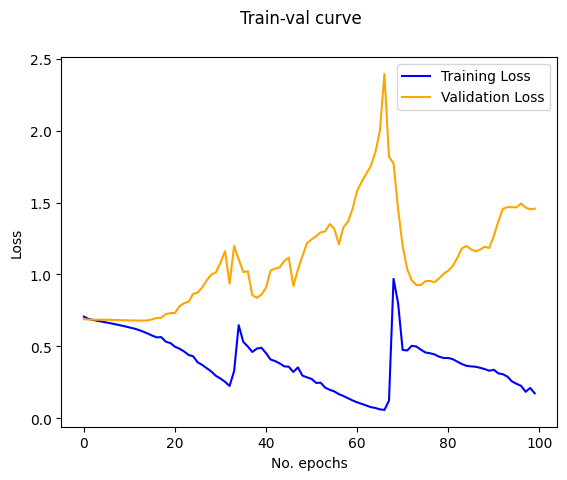

0.625


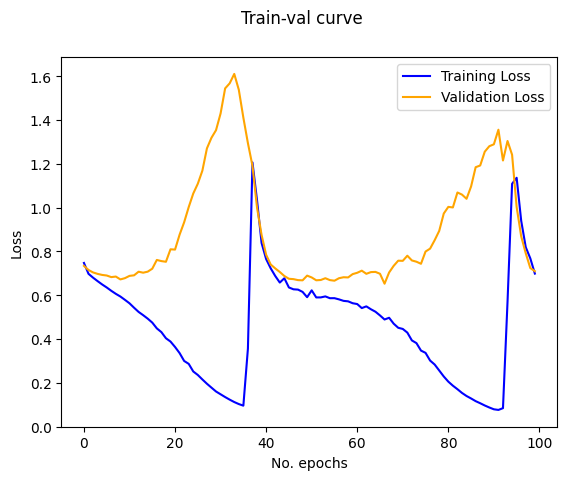

0.5


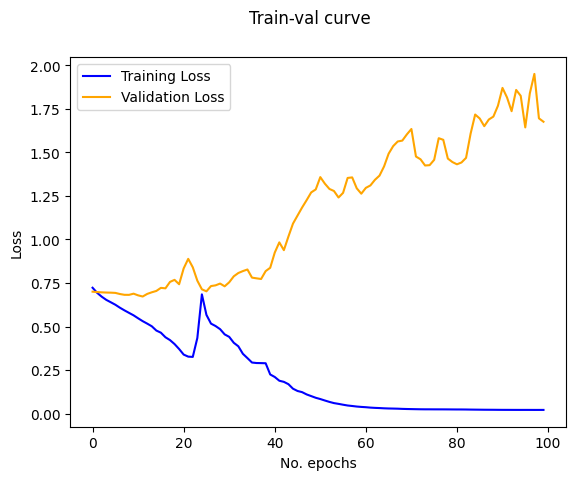

0.75


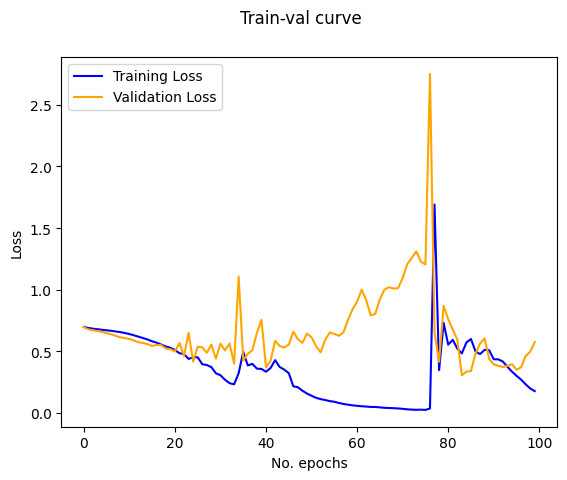

0.5714285714285714


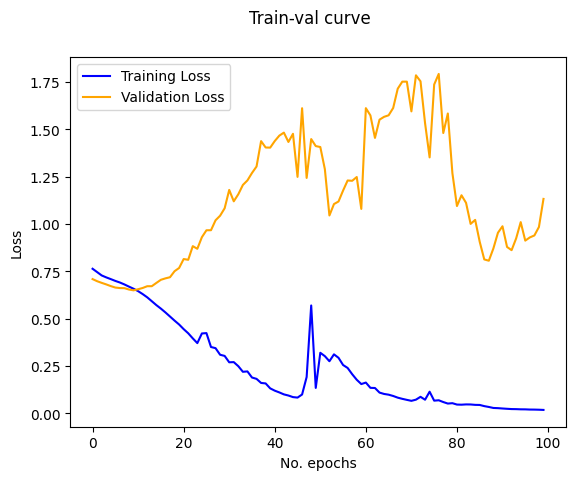

In [41]:
def plot_train_val_curve(train_loss:list, val_loss:list) -> None:
    '''function for plotting train-val curve while trianing neural network
    Args:
        train_loss - list with losses obtained during training
        val_loss - list with losses obtained during validation
        runname - runname, will be used while saving
    Out:
        None
    '''
    #assert same length
    assert len(train_loss)==len(val_loss)
    epoch_list = [i for i in range(len(train_loss))]
    
    #plot
    plt.plot(epoch_list, train_loss, 'blue', label='Training Loss')
    plt.plot(epoch_list, val_loss, 'orange', label='Validation Loss')
    plt.xlabel('No. epochs')
    plt.ylabel('Loss')
    plt.suptitle('Train-val curve')
    plt.legend()
    plt.show()
    
for i in range(5):
    print(fold_performance[i])
    plot_train_val_curve(fold_results[i]['train'],fold_results[i]['val'])

We can clearly see that we get nice loss function for train curve but our validation curve is very unstable. This means two things:
* good thing is that our model is consistently able to learn from the data and make predictions based on our features (if our features were 'random' or badly engineered, the training loss wouldn decrease so nicely
* bad thing is that it is not generalizing well i.e. its overfitting as the validation curve is a bit crazy. This is to be expected with so many features and more feature engineering would be required to get an optimal number of features while keeping all useful information. As I don't have enough time to explore all feature engineering options, I will instead aim to improve the model performance as it is now through some changes to the architecture & training environment

I will add dropout & l2 penalization to hopefully reduce the overfitting. I can also play with the learning rate & number of epochs to see which is the most optimal one. Increasing the learning rate might be a good first step.

In [42]:
# Define modified LSTM model
class LSTMModel_general(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel_general, self).__init__()
        self.hidden_size = hidden_size #required for RNN to keep 'memory'
        self.num_layers = num_layers 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() #required for binary classification
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # initialize randomly
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.dropout(out)
        out = out[:, -1, :]
        out = self.fc(out) 
        out = self.sigmoid(out)
        return out
        
#update train env
def run_training(model, data, targets, train_ids, val_ids, log_dict, i, epochs, lr):
    # instantiate loss function, set up variables
    criterion = nn.BCELoss()
    best_val_loss = float('inf') #set it up 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay =0.01)
    num_epochs = epochs
    
    #training 
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        for mode in ['train','val']:
            targets = torch.tensor(targets, dtype=torch.float32)
            if mode=='train':
                model.train()
                optimizer.zero_grad()
                outputs = model(data[train_ids])
                loss = criterion(outputs.squeeze(), targets[train_ids])
                print('train loss:',loss.item())
                loss.backward()
                optimizer.step()
                log_dict['train'].append(loss.item())
            else:
                model.eval()
                with torch.no_grad():
                    outputs = model(data[val_ids])
                    loss = criterion(outputs.squeeze(), targets[val_ids])
                    print('val loss:',loss.item())

                #save model which achieved best validation
                if loss.item() < best_val_loss:
                    print('best model so far, saving')
                    torch.save(model.state_dict(), f'results/best_model_cv{i}.pth')
                    best_val_loss = loss.item()
                log_dict['val'].append(loss.item())
                
    #save final model
    print('training finished, saving final model')
    torch.save(model.state_dict(), f'results/final_model_cv{i}.pth')
    return metrics.accuracy_score(targets[val_ids], outputs.squeeze().round())

def run_cv_training(data, targets, n_epochs=100, learning_r=0.01):
    #instantiate kfold, log_dictionaries
    kfold = KFold(5, shuffle=True, random_state=38)
    fold_loss={}
    fold_performance={}
    start = time.time()

    #set up variables
    input_size = data.shape[2]  
    hidden_size = 8
    num_layers = 1
    output_size = 1 
    
    #start cross-validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train)):
        print(fold)
        fold_loss[fold]={'train':[], 'val':[]}
        
        # instantiate new model for each fold
        model = LSTMModel_general(input_size, hidden_size, num_layers, output_size)
    
        #train
        fold_performance[fold]=run_training(model, data, targets, train_ids, val_ids, fold_loss[fold], fold, epochs=100, lr=learning_r)
                        
    end=time.time()
    print('Total inference time for CV training (in second): ', end-start)
    return fold_loss, fold_performance



In [624]:
fold_results, fold_performance = run_cv_training(torch.tensor(np.array(X_train), dtype=torch.float32), y_train, learning_r=0.001)

0
Epoch [1/100]
train loss: 0.6572776436805725
val loss: 0.722745418548584
best model so far, saving
Epoch [2/100]
train loss: 0.652759850025177
val loss: 0.7230318188667297
Epoch [3/100]
train loss: 0.6512101292610168
val loss: 0.7233002185821533
Epoch [4/100]
train loss: 0.6509719491004944


C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.7235381603240967
Epoch [5/100]
train loss: 0.6502541899681091
val loss: 0.7237273454666138
Epoch [6/100]
train loss: 0.648099958896637
val loss: 0.7239108681678772
Epoch [7/100]
train loss: 0.6406876444816589
val loss: 0.7240632176399231
Epoch [8/100]
train loss: 0.636234700679779
val loss: 0.7241978645324707
Epoch [9/100]
train loss: 0.6411911845207214
val loss: 0.7243171334266663
Epoch [10/100]
train loss: 0.6385974884033203
val loss: 0.7244104743003845
Epoch [11/100]
train loss: 0.6243019104003906
val loss: 0.7244860529899597
Epoch [12/100]
train loss: 0.6316726207733154
val loss: 0.7245265245437622
Epoch [13/100]
train loss: 0.6269685626029968
val loss: 0.7245218753814697
Epoch [14/100]
train loss: 0.6235800385475159
val loss: 0.7244542837142944
Epoch [15/100]
train loss: 0.6232297420501709
val loss: 0.7242833971977234
Epoch [16/100]
train loss: 0.6213806867599487
val loss: 0.72397381067276
Epoch [17/100]
train loss: 0.6181238293647766
val loss: 0.7234965562820435
Epoch

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6986690759658813
best model so far, saving
Epoch [3/100]
train loss: 0.6740302443504333
val loss: 0.6984149217605591
best model so far, saving
Epoch [4/100]
train loss: 0.6693040728569031
val loss: 0.6981858015060425
best model so far, saving
Epoch [5/100]
train loss: 0.6713991761207581
val loss: 0.6979516744613647
best model so far, saving
Epoch [6/100]
train loss: 0.6678529977798462
val loss: 0.6977410912513733
best model so far, saving
Epoch [7/100]
train loss: 0.6671158671379089
val loss: 0.6975478529930115
best model so far, saving
Epoch [8/100]
train loss: 0.6631988286972046
val loss: 0.6973766684532166
best model so far, saving
Epoch [9/100]
train loss: 0.6705967783927917
val loss: 0.6972052454948425
best model so far, saving
Epoch [10/100]
train loss: 0.6641030311584473
val loss: 0.6970416903495789
best model so far, saving
Epoch [11/100]
train loss: 0.662726640701294
val loss: 0.696855902671814
best model so far, saving
Epoch [12/100]
train loss: 0.6531311869621277

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6826537847518921
best model so far, saving
Epoch [3/100]
train loss: 0.7002292275428772
val loss: 0.6820911169052124
best model so far, saving
Epoch [4/100]
train loss: 0.6881564259529114
val loss: 0.6815111637115479
best model so far, saving
Epoch [5/100]
train loss: 0.6755287051200867
val loss: 0.6809360980987549
best model so far, saving
Epoch [6/100]
train loss: 0.6825228333473206
val loss: 0.6803795099258423
best model so far, saving
Epoch [7/100]
train loss: 0.6750514507293701
val loss: 0.6798304319381714
best model so far, saving
Epoch [8/100]
train loss: 0.6784538626670837
val loss: 0.6792926788330078
best model so far, saving
Epoch [9/100]
train loss: 0.6580807566642761
val loss: 0.6787797808647156
best model so far, saving
Epoch [10/100]
train loss: 0.6694760322570801
val loss: 0.6782768964767456
best model so far, saving
Epoch [11/100]
train loss: 0.6552548408508301
val loss: 0.6777676343917847
best model so far, saving
Epoch [12/100]
train loss: 0.65789389610290

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6428244709968567
best model so far, saving
Epoch [5/100]
train loss: 0.6551895141601562
val loss: 0.6422761678695679
best model so far, saving
Epoch [6/100]
train loss: 0.6501570343971252
val loss: 0.6417247653007507
best model so far, saving
Epoch [7/100]
train loss: 0.6558371782302856
val loss: 0.6411867737770081
best model so far, saving
Epoch [8/100]
train loss: 0.6461989879608154
val loss: 0.6406154632568359
best model so far, saving
Epoch [9/100]
train loss: 0.6455867886543274
val loss: 0.6400405764579773
best model so far, saving
Epoch [10/100]
train loss: 0.642002284526825
val loss: 0.6394692659378052
best model so far, saving
Epoch [11/100]
train loss: 0.6457881927490234
val loss: 0.6388823986053467
best model so far, saving
Epoch [12/100]
train loss: 0.6469353437423706
val loss: 0.6383213996887207
best model so far, saving
Epoch [13/100]
train loss: 0.6383915543556213
val loss: 0.6377760767936707
best model so far, saving
Epoch [14/100]
train loss: 0.6371512413024

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\777347659.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6850966811180115
best model so far, saving
Epoch [2/100]
train loss: 0.6828692555427551
val loss: 0.685003399848938
best model so far, saving
Epoch [3/100]
train loss: 0.6838172078132629
val loss: 0.6849203109741211
best model so far, saving
Epoch [4/100]
train loss: 0.6807646155357361
val loss: 0.6848474740982056
best model so far, saving
Epoch [5/100]
train loss: 0.6796972751617432
val loss: 0.6847790479660034
best model so far, saving
Epoch [6/100]
train loss: 0.6801503300666809
val loss: 0.684705913066864
best model so far, saving
Epoch [7/100]
train loss: 0.6774388551712036
val loss: 0.6846365928649902
best model so far, saving
Epoch [8/100]
train loss: 0.6782612800598145
val loss: 0.6845706105232239
best model so far, saving
Epoch [9/100]
train loss: 0.6800305247306824
val loss: 0.6845055222511292
best model so far, saving
Epoch [10/100]
train loss: 0.6759532690048218
val loss: 0.6844391822814941
best model so far, saving
Epoch [11/100]
train loss: 0.6756747364997864


0.5


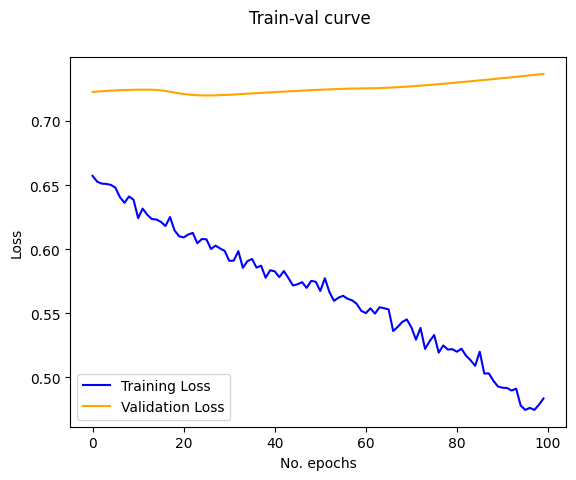

0.375


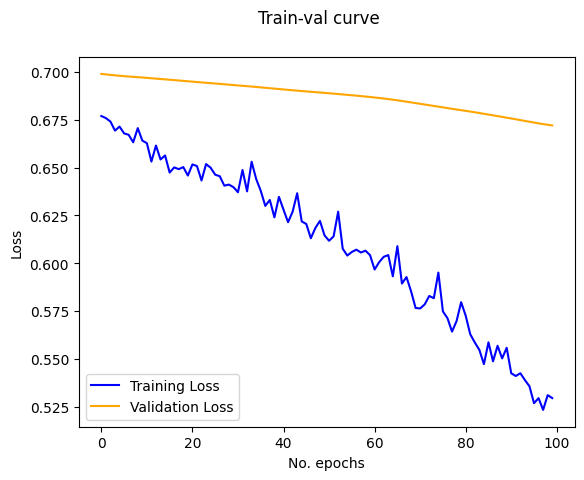

0.875


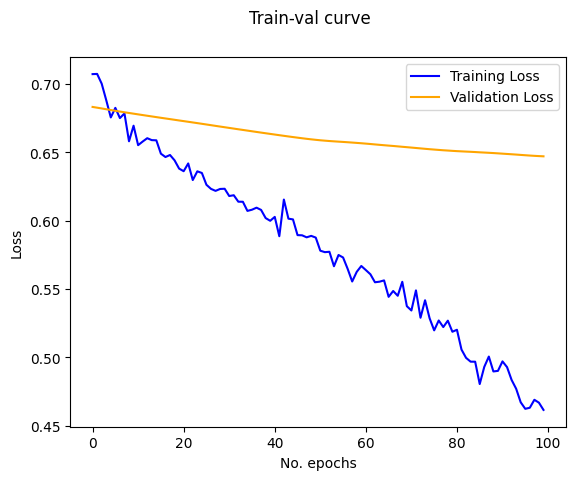

1.0


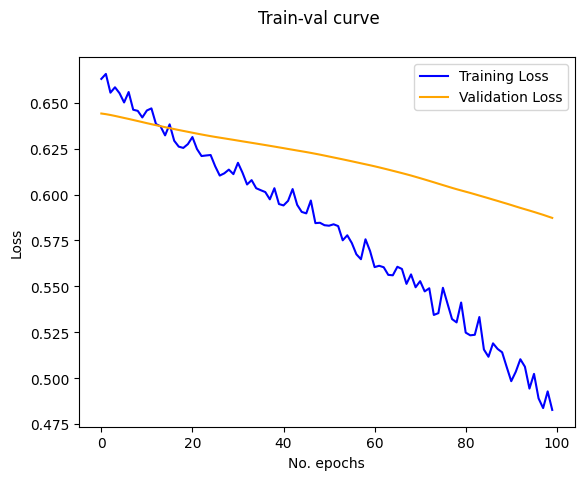

0.5714285714285714


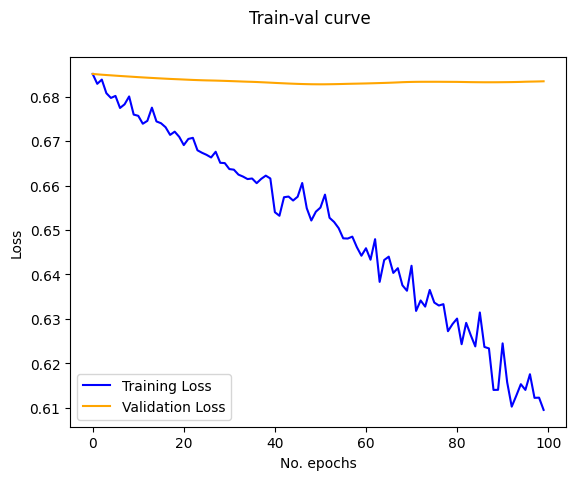

In [625]:
for i in range(5):
    print(fold_performance[i])
    plot_train_val_curve(fold_results[i]['train'],fold_results[i]['val'])

Decreasing the learning rate hasnt improved the results but made training more consistent; lets try increasing

In [626]:
fold_results, fold_performance = run_cv_training(torch.tensor(np.array(X_train), dtype=torch.float32), y_train, n_epochs=100, learning_r=0.1)

0
Epoch [1/100]
train loss: 0.6731417179107666
val loss: 0.7099515199661255
best model so far, saving
Epoch [2/100]
train loss: 0.590477466583252
val loss: 0.7579940557479858
Epoch [3/100]
train loss: 0.47525960206985474
val loss: 0.893721878528595
Epoch [4/100]
train loss: 0.3841564357280731


C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.9446908831596375
Epoch [5/100]
train loss: 0.23301732540130615
val loss: 1.169755220413208
Epoch [6/100]
train loss: 0.12040350586175919
val loss: 1.4813987016677856
Epoch [7/100]
train loss: 0.0628747045993805
val loss: 1.6434681415557861
Epoch [8/100]
train loss: 0.026728665456175804
val loss: 2.0257771015167236
Epoch [9/100]
train loss: 0.022140998393297195
val loss: 2.3882827758789062
Epoch [10/100]
train loss: 0.01143823005259037
val loss: 2.405752658843994
Epoch [11/100]
train loss: 0.01536566112190485
val loss: 2.069509983062744
Epoch [12/100]
train loss: 0.0132419653236866
val loss: 1.7750996351242065
Epoch [13/100]
train loss: 0.09127611666917801
val loss: 2.3417670726776123
Epoch [14/100]
train loss: 0.1591690480709076
val loss: 2.139777660369873
Epoch [15/100]
train loss: 0.05713251605629921
val loss: 1.5290240049362183
Epoch [16/100]
train loss: 0.19793851673603058
val loss: 2.2462189197540283
Epoch [17/100]
train loss: 0.07295724004507065
val loss: 2.3411107063

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6647177934646606
best model so far, saving
Epoch [2/100]
train loss: 0.6630881428718567
val loss: 0.653210461139679
best model so far, saving
Epoch [3/100]
train loss: 0.6049377918243408
val loss: 0.6125869154930115
best model so far, saving
Epoch [4/100]
train loss: 0.5368497371673584
val loss: 0.6087750792503357
best model so far, saving
Epoch [5/100]
train loss: 0.3697998821735382
val loss: 0.6582742929458618
Epoch [6/100]
train loss: 0.23383726179599762
val loss: 0.787219762802124
Epoch [7/100]
train loss: 0.11286014318466187
val loss: 0.9055755138397217
Epoch [8/100]
train loss: 0.07918306440114975
val loss: 0.7356888055801392
Epoch [9/100]
train loss: 0.038953348994255066
val loss: 0.6143030524253845
Epoch [10/100]
train loss: 0.028338884934782982
val loss: 0.6788911819458008
Epoch [11/100]
train loss: 0.018137754872441292
val loss: 0.9498052597045898
Epoch [12/100]
train loss: 0.013811175711452961
val loss: 1.654847502708435
Epoch [13/100]
train loss: 0.1694772094488

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


train loss: 0.6674194931983948
val loss: 0.6659348011016846
best model so far, saving
Epoch [2/100]
train loss: 0.6234701871871948
val loss: 0.680799663066864
Epoch [3/100]
train loss: 0.5875316858291626
val loss: 0.6677384972572327
Epoch [4/100]
train loss: 0.5283263921737671
val loss: 0.6432428359985352
best model so far, saving
Epoch [5/100]
train loss: 0.38003402948379517
val loss: 0.6658687591552734
Epoch [6/100]
train loss: 0.21847650408744812
val loss: 0.9027755260467529
Epoch [7/100]
train loss: 0.1047138124704361
val loss: 1.4455863237380981
Epoch [8/100]
train loss: 0.07465305179357529
val loss: 1.5784497261047363
Epoch [9/100]
train loss: 0.036994289606809616
val loss: 1.7676645517349243
Epoch [10/100]
train loss: 0.020080873742699623
val loss: 1.3351954221725464
Epoch [11/100]
train loss: 0.020070547237992287
val loss: 1.5709526538848877
Epoch [12/100]
train loss: 0.019548840820789337
val loss: 1.883037805557251
Epoch [13/100]
train loss: 0.01210781093686819
val loss: 1.176

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.6040853261947632
best model so far, saving
Epoch [2/100]
train loss: 0.6099913716316223
val loss: 0.5950341820716858
best model so far, saving
Epoch [3/100]
train loss: 0.5378570556640625
val loss: 0.4965749979019165
best model so far, saving
Epoch [4/100]
train loss: 0.42369645833969116
val loss: 0.4927380084991455
best model so far, saving
Epoch [5/100]
train loss: 0.201188862323761
val loss: 0.6015404462814331
Epoch [6/100]
train loss: 0.0941351130604744
val loss: 0.804567277431488
Epoch [7/100]
train loss: 0.04061438515782356
val loss: 0.9133793115615845
Epoch [8/100]
train loss: 0.02368643321096897
val loss: 0.8241915106773376
Epoch [9/100]
train loss: 0.01128416508436203
val loss: 0.7564917206764221
Epoch [10/100]
train loss: 0.011303635314106941
val loss: 0.8697558641433716
Epoch [11/100]
train loss: 0.11529906094074249
val loss: 0.9209190607070923
Epoch [12/100]
train loss: 0.04702793434262276
val loss: 0.9482631087303162
Epoch [13/100]
train loss: 0.024672362953424

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(targets, dtype=torch.float32)
C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1463835825.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


val loss: 0.8055540919303894
Epoch [4/100]
train loss: 0.45170220732688904
val loss: 0.9421424865722656
Epoch [5/100]
train loss: 0.24127289652824402
val loss: 0.8617036938667297
Epoch [6/100]
train loss: 0.12679915130138397
val loss: 0.6255412697792053
best model so far, saving
Epoch [7/100]
train loss: 0.059895746409893036
val loss: 0.586854100227356
best model so far, saving
Epoch [8/100]
train loss: 0.03408360481262207
val loss: 0.6042889952659607
Epoch [9/100]
train loss: 0.021327443420886993
val loss: 0.6876534819602966
Epoch [10/100]
train loss: 0.02094339206814766
val loss: 0.803665280342102
Epoch [11/100]
train loss: 0.07438361644744873
val loss: 1.375481367111206
Epoch [12/100]
train loss: 0.29832035303115845
val loss: 0.8465933799743652
Epoch [13/100]
train loss: 0.20607545971870422
val loss: 0.6385275721549988
Epoch [14/100]
train loss: 0.07996731996536255
val loss: 0.6925176382064819
Epoch [15/100]
train loss: 0.03640642762184143
val loss: 0.9042128324508667
Epoch [16/100]

0.5


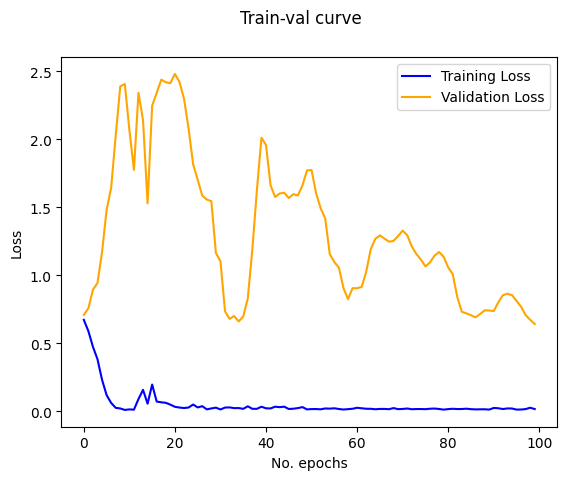

0.75


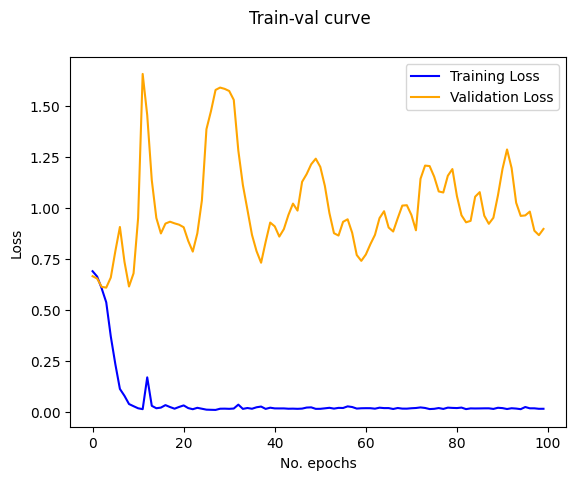

1.0


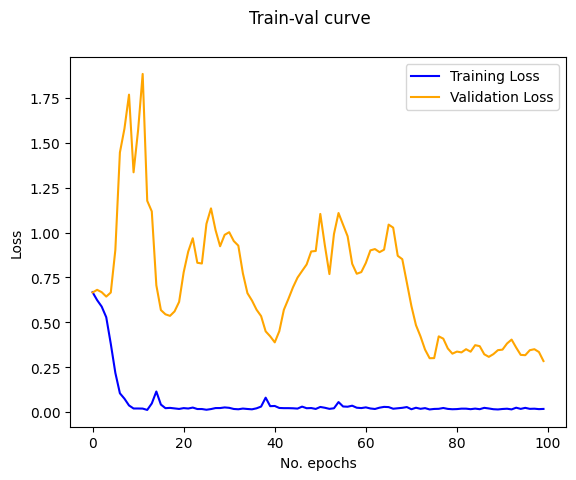

0.375


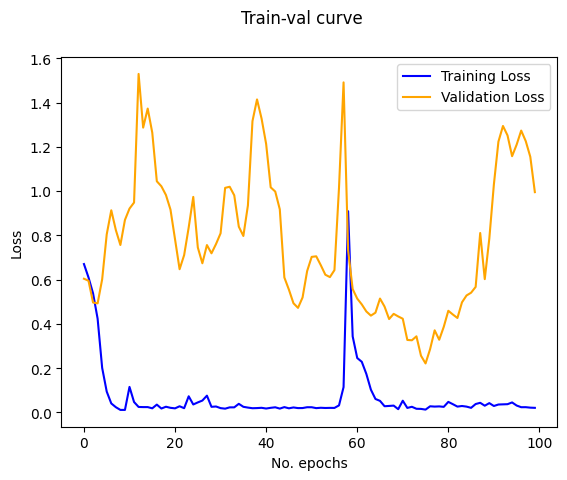

0.7142857142857143


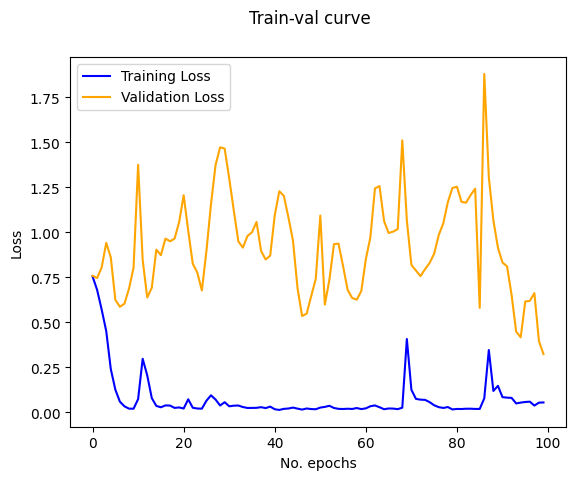

In [627]:
#plot  
for i in range(5):
    print(fold_performance[i])
    plot_train_val_curve(fold_results[i]['train'],fold_results[i]['val'])

The training and val curves are much less stable (to be expected with overshooting lr) but performance overall seems better; we could do that for a while so instead I will now examine the performance of the model on the test set 

In [52]:
def run_training(model, data, targets, train_ids, val_ids, log_dict, i, epochs=100, lr=0.01):
    # Loss function and optimizer
    criterion = nn.BCELoss()
    best_val_loss = float('inf')
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay =0.01)
    # Training loop (assuming you have labels/targets for training)
    num_epochs = epochs
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        for mode in ['train','val']:
            targets = torch.tensor(targets, dtype=torch.float32)
            if mode=='train':
                model.train()
                optimizer.zero_grad()
                outputs = model(data[train_ids])
                loss = criterion(outputs.squeeze(), targets[train_ids])
                print('train loss:',loss.item())
                loss.backward()
                optimizer.step()
                log_dict['train'].append(loss.item())
            else:
                model.eval()
                with torch.no_grad():
                    outputs = model(data[val_ids])
                    loss = criterion(outputs.squeeze(), targets[val_ids])
                    print('val loss:',loss.item())
                    
                if loss.item() < best_val_loss:
                    print('best model so far, saving')
                    torch.save(model.state_dict(), f'results/best_model_cv{i}.pth')
                    best_val_loss = loss.item()
                log_dict['val'].append(loss.item())
    print('training finished, saving final model')
    torch.save(model.state_dict(), f'results/final_model_cv{i}.pth')
                
def run_cv_training(data, targets, epochs=100, lr=0.1):
    kfold = KFold(1, shuffle=True, random_state=38)

    fold_results={}
    
    start = time.time()
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train)):
        print(fold)
        fold_results[fold]={'train':[], 'val':[]}
        input_size = 26472 
        hidden_size = 8
        num_layers = 1
        output_size = 1 
        
        # instantiate the model
        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    
        #train
        run_training(model, data, targets, train_ids, val_ids, fold_results[fold], fold, epochs=100, lr=0.1)
        
                        
    end=time.time()
    print('Total inference time for CV training (in second): ', end-start)
    return fold_results

fold_results = run_cv_training(torch.tensor(np.array(X_train), dtype=torch.float32), y_train)#, total_length)

C:\Users\kjvf934\AppData\Local\Temp\ipykernel_26780\1319462087.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = torch.tensor(y_train, dtype=torch.float32)


Epoch [1/500], Loss: 0.706062912940979
Epoch [2/500], Loss: 0.7022513151168823
Epoch [3/500], Loss: 0.6985377073287964
Epoch [4/500], Loss: 0.6949195861816406
Epoch [5/500], Loss: 0.691393256187439
Epoch [6/500], Loss: 0.6879542469978333
Epoch [7/500], Loss: 0.6845966577529907
Epoch [8/500], Loss: 0.6813150644302368
Epoch [9/500], Loss: 0.6781038641929626
Epoch [10/500], Loss: 0.6749584078788757
Epoch [11/500], Loss: 0.6718744039535522
Epoch [12/500], Loss: 0.6688476800918579
Epoch [13/500], Loss: 0.6658748388290405
Epoch [14/500], Loss: 0.6629523634910583
Epoch [15/500], Loss: 0.6600769758224487
Epoch [16/500], Loss: 0.6572460532188416
Epoch [17/500], Loss: 0.6544567346572876
Epoch [18/500], Loss: 0.6517060995101929
Epoch [19/500], Loss: 0.6489918231964111
Epoch [20/500], Loss: 0.6463109850883484
Epoch [21/500], Loss: 0.643660843372345
Epoch [22/500], Loss: 0.6410380601882935
Epoch [23/500], Loss: 0.638438880443573
Epoch [24/500], Loss: 0.6358595490455627
Epoch [25/500], Loss: 0.63329

### Testing

In [43]:
#load state_dict
state_dict = torch.load('results/best_model_cv3.pth') #possible best cv model based on the plots
model = LSTMModel_general(26472, 8, 1, 1)
model.load_state_dict(state_dict)

#test performance
start = time.time()
model.eval()
result = []
for i in range(len(X_test)):
    output =model(torch.tensor(np.array(X_test))[i].unsqueeze(0))
    result.append(output.round().detach().cpu().numpy())
end = time.time()

print('Total inference time for entire test set (in second): ', end-start)
result = [i[0][0] for i in result]

Total inference time for entire test set (in second):  0.15761399269104004


In [44]:
print(metrics.confusion_matrix(y_test, result))
print(metrics.accuracy_score(y_test, result))


[[1 3]
 [0 7]]
0.7272727272727273


The model performs with 73% accuracy and has relatively quick training & inference time

## Final remarks

Due to time constraints I wont have time to export & validate the model into onnx format; while it's definitely beneficial from deployment perspective, for the purpose of this task I will skip it.

If I had more time, I would have done the following: 
* explore finetuning of the hyperparameters (eg can use RayTune instead of manual changes)
* explore the feature importance during the cross validation to confirm generelizability(can use SHAP)
* explore other feature engineering approaches and see which works best (and how to reduce the high dimensionality of features)
* try more models & benchmark 
* write some unit tests to ensure code's reliability (normally would be done in parallel to coding but couldn't do it this time due to time constraints)
* test the model with unseen data (if available)
* divide the notebook into documented scripts according to good software development practice - my preferred way of working is also within scripts and I am not very used to notebooks but for the sake of this excercise I used the notebooks
                                        